In [1232]:

import numpy as np                          # for scientific computing
import pandas as pd                         # for data analysis and creating attenuation coefficient dictionaries        
import spekpy as sp                         # for getting poly-chromatic x-rays
import tifffile as tf                       # for writing the image as tiff file
from matplotlib import pyplot as plt        # for saving the image
import matplotlib.pyplot as plt


In [1233]:
##################################### defining attenuation coefficient dictionaries ###########################################

# arguments: XmuDat data directory, seperator is space and there is no header
df = pd.read_csv('../Code/attenuation_coefficeint_data.txt', sep='\s+', header = None)
# define headers for columns in dataframe by assigning names for columns
df.columns = ['Energy', 'tissue', 'water', 'bone', 'calcium', 'Iodine water']
# define a dictionary of density of input materials in g/cm^3 (based on XmuDat)
density = {'tissue' :1, 'water' : 1, 'bone' : 1.85, 'calcium' : 1.55, 'Iodine water': 1.01}

# converting columns of df (dataframe) to list for further use in dictionary, note that XmuDat gives mu/density,
# thereby it is needed to multiply it to density of each material:
mu_tissue = list(df['tissue']  * density['tissue'])
mu_water = list(df['water'] * density['water'])
mu_bone = list(df['bone'] * density ['bone'])
mu_calcium = list(df['calcium'] * density['calcium'])
mu_iodine_water = list(df['Iodine water'] * density['Iodine water'])
energy = list(df['Energy'])

#defining dictionaries for linear attenuation coeffiecients in 1/cm
#in these dictionaries, key is i (energies), value is j (attenuation coefficients), zip function makes a pair of E and mu
mu_tissue_dict = {float(i): j for i,j in zip(energy, mu_tissue)}
mu_water_dict = {float(i): j for i,j in zip(energy, mu_water)}
mu_bone_dict = {float(i): j for i,j in zip(energy, mu_bone)}
mu_calcium_dict = {float(i): j for i,j in zip(energy, mu_calcium)}
mu_iodine_dict = {float(i): j for i,j in zip(energy, mu_iodine_water)}

#defining refrence dictionary for mu, key is compsition material and values are attenuation coefficients in 1/cm
all_mu = {'tissue': mu_tissue_dict, 'water': mu_water_dict, 'bone': mu_bone_dict, 'calcium': mu_calcium_dict, 'Iodine water' : mu_iodine_dict}

In [1234]:
elu = [i for i in range(1, 101)]

In [1235]:
preset_values = {'kvp_ent': 100, 'targ_ent': 'W', 'theta_ent': 12, 'mas_ent': 100, 'filter_ent': 'Al', 'xfilter_ent': 3,
                 'obj_ent': 'tissue', 'det_ent': 'bone', 'sdd_ent': 150, 'ssd_ent': 100, 'pixel_size': 0.005, 'FOV_ent': 2,
                 'scatter_ent': 0, 'det_radius': 0.5, 'xdet_ent': 5, 'xobj_ent': 0.5}

In [1236]:
# entries for x-ray tube, note that the entries from GUI are strings,
# so for the numerical variables it is needed to convert them to numerical datatypes such as float or int
kvp_data = preset_values['kvp_ent']             # kilovoltage peak in kVp
targ_data = preset_values['targ_ent']                  # target material (can only be W, Mo, Rh based on spekpy limitations)
theta = preset_values['theta_ent']                # anode angle in degrees
mas_data = preset_values['mas_ent']               # milliamperage (mAs)
filter_data = preset_values['filter_ent']              # selected material for filter
xfilter_data = preset_values['xfilter_ent']     # thickness of filter in mm
    
# entries for geometry and phantom properties
sdd = preset_values['sdd_ent']                  # source to detector distance
ssd = preset_values['ssd_ent']                  # source to skin (object) distance
obj_material = preset_values['obj_ent']                # object type
det_material = preset_values['det_ent']                # detail type 
det_rad_cm = preset_values['det_radius']        # detail radius
xobj = preset_values['xobj_ent']                # object thickness
xdet = preset_values['xdet_ent']                # detail thickness
    
# define mu dictionaries for object and detail for attenuation calculations based of the selected material by user
obj_dict = all_mu[obj_material]
det_dict = all_mu[det_material] 
    
#entries for image
pixel = preset_values['pixel_size']                 # getting pixel size from entries for image formation
scatter_ratio = preset_values['scatter_ent']        # getting scatter to primary ratio for scatter component
field = preset_values ['FOV_ent']                    # defining field of view for image formation
    
#calculation 
matrix = int(field/pixel)                       # defining number of pixels in every direction of field of view
det_rad_pixel = det_rad_cm/pixel                # converting detail radius from cm to pixel for image formation

In [1237]:
# test
print(matrix)

400


In [1238]:
############################### getting x-ray spectra #####################

# create X-ray spectrum with given kilovoltage peak, target material and angle and tube load in distance z (SSD),
# before entering the phantom with inherent filteration
s = sp.Spek(kvp = kvp_data, th = theta, targ = targ_data, mas = mas_data, z = ssd, physics = 'kqp', mu_data_source = 'pene', dk = 1).filter('Al', 1)
s.summarize()

Inputs
------
Tube Voltage: 100.0 [kVp]; Anode Angle: 12.0 [degrees]; Energy Bin: 1.0 [keV]; Bin shift fraction: None []; Physics Mode: spekpy-v2-kqp [str]; Mu Data Source: pene [str]; Target: W [str]; 
x: 0.0 [cm]; y: 0.0 [cm]; z: 100.0 [cm]; Tube Load: 100.0 [mAs]; Bremsstrahlung Emission: True [bool]; Characteristic Emission: True [bool]; Oblique: True [bool]; Ref. air Kerma: None [uGy]; Ref. fluence: None [Photons cm^-2]; 
Filtration: [('Al', 1)] [mm]; 



In [1239]:
       
# filteration: filter material and thickness
s.filter(matl = filter_data, t = xfilter_data)

# The get_spectrum method in SpekPy returns two arrays; k contains the energy bins of the spectrum (keV) and f contains the
# corresponding differential fluences (photons keV−1 mAs−1 cm−2).
# If edges is specified as True, 
# the arrays are returned in "stair-case" or "Monte Carlo" style format.
k, f = s.get_spectrum(edges = True)

In [1240]:
# test getting the spectrum
for i,j in zip(k,f):
    print(i,j)

1.0 4.280069494002281e-164
2.0 4.280069494002281e-164
2.0 0.0
3.0 0.0
3.0 1.8110592374962987e-234
4.0 1.8110592374962987e-234
4.0 5.996720899642354e-113
5.0 5.996720899642354e-113
5.0 1.5763810481655211e-60
6.0 1.5763810481655211e-60
6.0 2.6298038709535587e-34
7.0 2.6298038709535587e-34
7.0 1.1817961662227182e-19
8.0 1.1817961662227182e-19
8.0 3.414302139969486e-10
9.0 3.414302139969486e-10
9.0 8.813092242322175e-05
10.0 8.813092242322175e-05
10.0 0.03259317657444431
11.0 0.03259317657444431
11.0 13.78204394644501
12.0 13.78204394644501
12.0 325.9142266983386
13.0 325.9142266983386
13.0 6606.002404097115
14.0 6606.002404097115
14.0 65898.98167219623
15.0 65898.98167219623
15.0 381499.0577843233
16.0 381499.0577843233
16.0 1492151.4337864849
17.0 1492151.4337864849
17.0 4377908.45681029
18.0 4377908.45681029
18.0 10254422.486192325
19.0 10254422.486192325
19.0 20397426.283421323
20.0 20397426.283421323
20.0 35592634.76282177
21.0 35592634.76282177
21.0 56055005.29512949
22.0 56055005.29

In [1241]:
k = k[::2]                                          # removing duplicate values from k and converting ndarray to list
f = f[::2]                                          # removing duplicate values from f

In [1242]:
print(type(k))

<class 'numpy.ndarray'>


In [1243]:
# test removing the duplicated values in the spectrum
for i,j in zip(k,f):
    print(i,j)

1.0 4.280069494002281e-164
2.0 0.0
3.0 1.8110592374962987e-234
4.0 5.996720899642354e-113
5.0 1.5763810481655211e-60
6.0 2.6298038709535587e-34
7.0 1.1817961662227182e-19
8.0 3.414302139969486e-10
9.0 8.813092242322175e-05
10.0 0.03259317657444431
11.0 13.78204394644501
12.0 325.9142266983386
13.0 6606.002404097115
14.0 65898.98167219623
15.0 381499.0577843233
16.0 1492151.4337864849
17.0 4377908.45681029
18.0 10254422.486192325
19.0 20397426.283421323
20.0 35592634.76282177
21.0 56055005.29512949
22.0 81306997.78639989
23.0 110435448.35546546
24.0 142641267.83064196
25.0 176351196.17895493
26.0 210334454.06021538
27.0 243793567.0448851
28.0 274667916.17350656
29.0 303717338.79974544
30.0 329683982.65650976
31.0 352349994.10757446
32.0 372440475.1311132
33.0 389932682.66760707
34.0 404862039.7766708
35.0 416314697.12284935
36.0 424567315.1815168
37.0 430825713.13327295
38.0 435257823.3926303
39.0 438020988.29298604
40.0 438557678.4912888
41.0 437142929.05339426
42.0 434666375.20429695


In [1244]:
# setting initial value of n_in and n_out
n_out = 0                                           
n_in = 0                                            

# getting the number of photons when they arrive to detector,  
for i, j in zip(k, f):
    n_out += j * np.exp(-obj_dict[i]*xobj)
    n_in += j * np.exp(-obj_dict[i]*(xobj-xdet)-(det_dict[i]*xdet))

In [1245]:
print(n_in)
print(n_out)

2542662097.26529
17707768450.271145


185977393.5196516<br>
189984823.67020535<br>



In [1246]:
# Rescaling using Inverse square law
n_in = (ssd**2/sdd**2) * n_in
n_out = (ssd**2/sdd**2) * n_out
print(n_in)
print(n_out)

1130072043.2290177
7870119311.23162


In [1247]:
# rescaling to get number of photons per pixel
n_in = (pixel**2) * n_in
n_out = (pixel**2) * n_out
print(n_in)
print(n_out)

28251.801080725443
196752.9827807905


In [1248]:
# adding up scatter component    
n_in = n_in + scatter_ratio *n_out                        # calculating total number of photons passing through the detail
n_out = n_out + scatter_ratio *n_out                      # calculationg total number of photons in the background
print(n_in)
print(n_out)

28251.801080725443
196752.9827807905


[[196752.98278079 196752.98278079 196752.98278079 ... 196752.98278079
  196752.98278079 196752.98278079]
 [196752.98278079 196752.98278079 196752.98278079 ... 196752.98278079
  196752.98278079 196752.98278079]
 [196752.98278079 196752.98278079 196752.98278079 ... 196752.98278079
  196752.98278079 196752.98278079]
 ...
 [196752.98278079 196752.98278079 196752.98278079 ... 196752.98278079
  196752.98278079 196752.98278079]
 [196752.98278079 196752.98278079 196752.98278079 ... 196752.98278079
  196752.98278079 196752.98278079]
 [196752.98278079 196752.98278079 196752.98278079 ... 196752.98278079
  196752.98278079 196752.98278079]]
<class 'numpy.ndarray'>


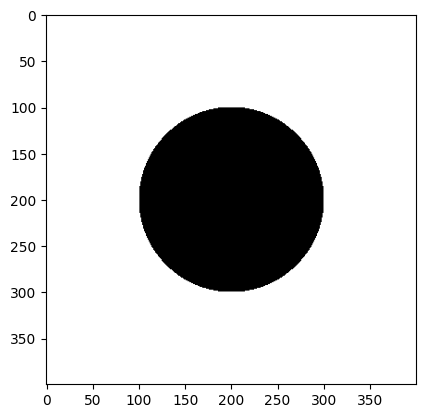

In [1249]:
# numpy arange retruns evenly spaced values within matrix size interval
rrange = np.arange((-matrix/2),(matrix/2))               
# using numpy tile function to divide the range into matrix number of tiles along first row to get x-coordinates
x_coord = np.tile(rrange ,(matrix ,1))     
# creating y coordinates by transposing x-coordinates
y_coord = np.transpose(x_coord)
    
# create img array using numpy where function; i.e:
# place the total number of photons passing through the detail inside a circle with detail radius in units of pixel
# and place the total number of photons in the background outside of the circle        
img_out = np.where(x_coord**2 + y_coord**2 < det_rad_pixel**2, n_in, n_out)

print(img_out)
print(type(img_out))
plt.imshow(img_out, cmap = 'gray')

[[196898. 197435. 196674. ... 196983. 196057. 197417.]
 [196732. 197109. 196629. ... 195778. 196421. 196983.]
 [195986. 197364. 196815. ... 196446. 196513. 196579.]
 ...
 [196314. 196397. 196049. ... 197931. 196127. 196280.]
 [195987. 196138. 196444. ... 196356. 197763. 196226.]
 [196487. 196952. 196786. ... 196505. 196707. 196813.]]
<class 'numpy.ndarray'>


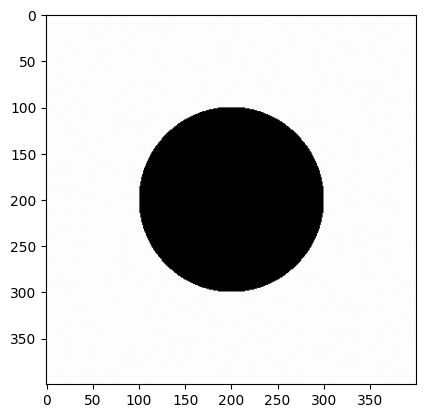

In [1250]:
img_ran = img_out               # defining a new variable as img_ran
for x in range(matrix):             # for every x in the range of matrix size
    for y in range(matrix):        # for every y in the range of matrix size        
        ii = img_out[x,y]                                       # getting the original pixel value at coordinates (x,y) in the image 
        img_ran[x,y] = np.random.poisson(lam = ii)                # assigning

print(img_ran)
print(type(img_ran))
plt.imshow(img_ran, cmap = 'gray')

[[196898. 197435. 196674. ... 196983. 196057. 197417.]
 [196732. 197109. 196629. ... 195778. 196421. 196983.]
 [195986. 197364. 196815. ... 196446. 196513. 196579.]
 ...
 [196314. 196397. 196049. ... 197931. 196127. 196280.]
 [195987. 196138. 196444. ... 196356. 197763. 196226.]
 [196487. 196952. 196786. ... 196505. 196707. 196813.]]
<class 'numpy.ndarray'>


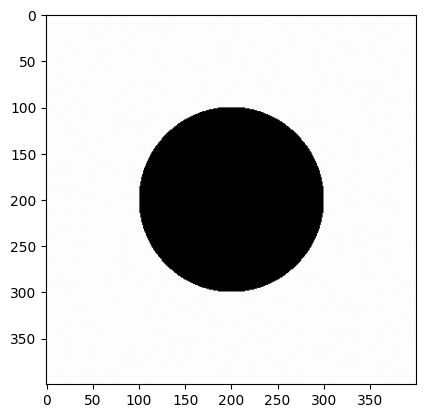

In [1251]:
img_32bit = img_ran.astype(np.float32)
print(img_32bit)
print(type(img_32bit))
plt.imshow(img_32bit, cmap = 'gray')


In [1252]:
n_in_avg = np.mean(img_ran[x_coord**2 + y_coord**2 < det_rad_pixel**2])         # 
n_out_avg = np.mean(img_ran[x_coord**2 + y_coord**2 >= det_rad_pixel**2])
contrast = ((n_out_avg - n_in_avg) / n_out_avg)
print(f"Contrast: {contrast:.2f}")

Contrast: 0.86
